In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
from scipy.stats import chi2
warnings.filterwarnings("error", category=RuntimeWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
dpann_phyla = ['Diapherotrites', 'Parvarchaeota', 'Aenigmarchaeota', 'Nanoarchaeota', 'Nanohaloarchaeota', 'Woesearchaeota', 'Pacearchaeota', 'Micrarchaeota', 'Altiarchaeota', 'Huberarchaeota', 'Undinarchaeota', 'Iainarchaeota']

levels = ['phylum', 'genus', 'class', 'order', 'species', 'domain', 'family']
level_funcs = dict(list(zip(levels, [get_phylum, get_genus, get_class, get_order, get_species, get_domain, get_family])))

In [10]:
metadata_df = load_metadata()
metadata_df = metadata_df[metadata_df.taxonomy.str.contains('Archaea')].copy() # Include only the archaea. 
print('Num. MAGs:', len(set(metadata_df.index.values)))

Num. MAGs: 71


In [11]:
metadata_df['phylum'] = metadata_df.taxonomy.apply(get_phylum)
metadata_df['dpann'] = metadata_df.phylum.isin(dpann_phyla)
print('Num. measurements for DPANN phyla:', metadata_df.dpann.sum())
print('Num. DPANN phyla:', metadata_df[metadata_df.dpann].index.nunique())

host_genome_ids = np.unique(metadata_df[~metadata_df.dpann].index.tolist())
symbiont_genome_ids = np.unique(metadata_df[metadata_df.dpann].index.tolist())
host_symbiont_pairs = [(host_genome_id, symbiont_genome_id) for i, host_genome_id in enumerate(host_genome_ids) for j, symbiont_genome_id in enumerate(symbiont_genome_ids) if j >= i]

Num. measurements for DPANN phyla: 120
Num. DPANN phyla: 30


In [5]:
# Seems possible to me that the host-symbiont relationships might not be the same in different nutrient conditions... 
# honestly wonder if they would differ in different levels of the reactor, but seems like I need more than one measurement. 

paired_df = list()
for location, df in metadata_df[metadata_df.nitrate].groupby('location'): # Look at each location separately. 
    for host_genome_id, symbiont_genome_id in tqdm(host_symbiont_pairs, desc=f'Retrieving pairwise relative abundance for {location} samples.'):
        row = {'host_genome_id':host_genome_id, 'symbiont_genome_id':symbiont_genome_id}
        row['host_relative_abundance'] = df.loc[host_genome_id].relative_abundance.item()
        row['symbiont_relative_abundance'] = df.loc[symbiont_genome_id].relative_abundance.item()
        row['location'] = location
        paired_df.append(row)
paired_df = pd.DataFrame(paired_df)
paired_df['pair_id'] = [f'{row.host_genome_id}:{row.symbiont_genome_id}' for row in paired_df.itertuples()]
paired_df.to_csv('paired_relative_abundance.csv')

Retrieving pairwise relative abundance for bottom samples.:   0%|          | 0/465 [00:00<?, ?it/s]

Retrieving pairwise relative abundance for bottom samples.: 100%|██████████| 465/465 [00:00<00:00, 7069.00it/s]
Retrieving pairwise relative abundance for middle samples.: 100%|██████████| 465/465 [00:00<00:00, 7267.10it/s]
Retrieving pairwise relative abundance for top samples.: 100%|██████████| 465/465 [00:00<00:00, 8271.74it/s]


In [6]:
def get_correlations(paired_df:pd.DataFrame):

    def get_correlation(df:pd.DataFrame):
        # Probably don't consider the cases where either, but not both, abundances are zero. 
        # Because there are only three data points, you'd get an R-squared of 1 just because there are two points. 
        try:
            x, y = df.host_relative_abundance.values, df.symbiont_relative_abundance.values 
            r = np.corrcoef(x, y)[0][1]
            m, b = np.polyfit(x, y, deg=1)

            # Don't trust the results if there are not more than two nonzero points. 
            n = len(x)
            n_both_zero = np.logical_and(x == 0, y == 0).sum()
            return {'r':r, 'slope':m, 'intercept':b, 'uncertain':((n - n_both_zero) < 3)}    
        except Exception as err:
            return dict()
    
    corr_df = paired_df.groupby('pair_id').apply(lambda df : get_correlation(df), include_groups=False)
    corr_df = pd.DataFrame(corr_df.values.tolist(), index=corr_df.index)
    # no_correlation_pair_ids = corr_df[corr_df.r.isnull()].index.values 
    # print(f'get_correlation: Failed on {len(no_correlation_pair_ids)} pairs.')
    corr_df = corr_df[~corr_df.r.isnull()].copy()
    corr_df['host_genome_id'] = [pair_id.split(':')[0] for pair_id in corr_df.index]
    corr_df['symbiont_genome_id'] = [pair_id.split(':')[1] for pair_id in corr_df.index]
    corr_df['uncertain'] = corr_df.uncertain.astype(bool)
    corr_df['r_squared'] = corr_df.r ** 2
    return corr_df

corr_df = get_correlations(paired_df)
# Slope is the ratio of relative abundance of the symbiont to relative abundance of the host. Not sure if there's 
# really any way to bound this value, as there can be multiple symbionts per host and it seems plausible that not every host
# will have a symbiont. 
corr_df = corr_df[corr_df.slope > 0].copy()

In [7]:
corr_df[f'host_taxonomy'] = corr_df[f'host_genome_id'].map(metadata_df[~metadata_df.index.duplicated()].taxonomy)
corr_df[f'symbiont_taxonomy'] = corr_df[f'symbiont_genome_id'].map(metadata_df[~metadata_df.index.duplicated()].taxonomy)

for level, level_func in level_funcs.items():
    corr_df[f'host_{level}'] = corr_df.host_taxonomy.apply(level_func)
    corr_df[f'symbiont_{level}'] = corr_df.symbiont_taxonomy.apply(level_func)

# I suspect the R squared value is misleading because in some cases, there will only be two points, so it is just 
# fitting a line. Not sure how many of these this is the case for. 


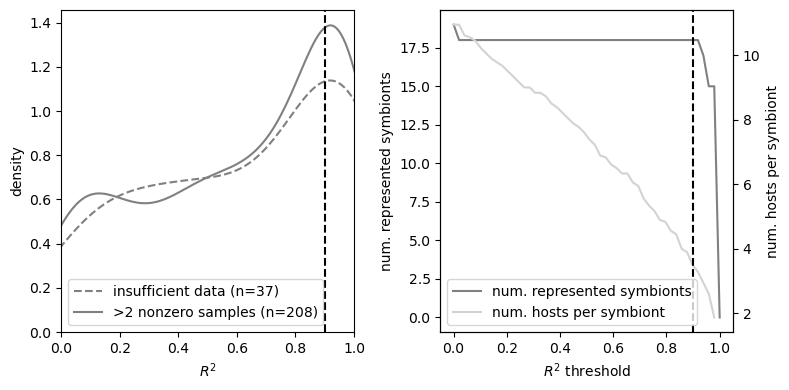

In [8]:
r_squared_threshold = 0.9

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

ax = axes[0]

figure_df = corr_df.copy()
sns.kdeplot(figure_df[figure_df.uncertain], x='r_squared', color='gray', ls='--', label=f'insufficient data (n={figure_df.uncertain.sum()})', ax=ax)
sns.kdeplot(figure_df[~figure_df.uncertain], x='r_squared', color='gray', ls='-', label=f'>2 nonzero samples (n={(~figure_df.uncertain).sum()})', ax=ax)
ax.legend()
ax.axvline(r_squared_threshold, ls='--', color='black')
# ax.text(0.2, 0.6, '$n_{R^2 > 0.7}$ = ' + str((figure_df.r_squared > 0.7).sum()), transform=ax.transAxes)
ax.set_ylabel('density')
ax.set_xlabel('$R^2$')
ax.set_xlim(xmin=0, xmax=1)

ax = axes[1]
# Want to look at the fraction of symbionts covered at different R thresholds. 
figure_df = list()
for threshold in np.linspace(0, 1, 50):
    mask = (~corr_df.uncertain) & (corr_df.r_squared > threshold)
    n_represented_symbionts = corr_df[mask].symbiont_genome_id.nunique()
    n_hosts_per_symbiont = corr_df[mask].groupby('symbiont_genome_id').size().mean()
    figure_df.append({'threshold':threshold, 'n_represented_symbionts':n_represented_symbionts, 'n_hosts_per_symbiont':n_hosts_per_symbiont})
figure_df = pd.DataFrame(figure_df)
sns.lineplot(figure_df, ax=ax, color='gray', x='threshold', y='n_represented_symbionts', label='num. represented symbionts')
ax.set_ylabel('num. represented symbionts')
ax.set_xlabel('$R^2$ threshold')
handles, labels = ax.get_legend_handles_labels()
ax.legend().remove()

ax = ax.twinx()
sns.lineplot(figure_df, ax=ax, color='lightgray', x='threshold', y='n_hosts_per_symbiont', label='num. hosts per symbiont')
ax.set_ylabel('num. hosts per symbiont')
ax.set_xlabel('$R^2$ threshold')
ax.axvline(r_squared_threshold, ls='--', color='black')
ax.legend().remove()

handles += ax.get_legend_handles_labels()[0]
labels += ax.get_legend_handles_labels()[1]
ax.legend(handles=handles, labels=labels, loc='lower left')

fig.tight_layout()
plt.show()

# https://www.pnas.org/doi/10.1073/pnas.2115449119 
# "Further host-switching experiments confirmed that ARM-1 grew on five different archaeal species from three genera—Metallosphaera, Acidianus, and Saccharolobus"


In [9]:
# corr_df.symbiont_order.value_counts() # Order is the lowest taxonomic level where every genome has an assignment. 
# Want to test to see if there is significant co-occurence between two discrete groups, which I think implies Chi-squared. 

level = 'order'
level = 'family'
table_df = pd.crosstab(corr_df[corr_df.r_squared > r_squared_threshold][f'host_{level}'], corr_df[corr_df.r_squared > r_squared_threshold][f'symbiont_{level}'])

N = table_df.sum().sum()
table_df = table_df[[col for col in table_df.columns if (col != 'none')]].copy()
table_df = table_df[table_df.index != 'none'].copy()

N_ = table_df.sum().sum()
print('Num. removed due to no taxonomic assignment:', N - N_)

Num. removed due to no taxonomic assignment: 3


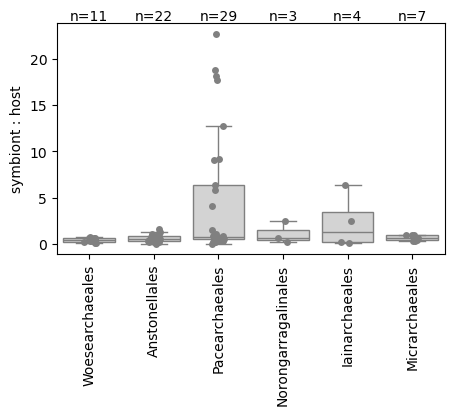

In [10]:
# Colin said that Saoirse has seen 7 or 8 CPR (?) per cell, some papers seem to indicate that there are around
# 3 DPANN per cell (https://pmc.ncbi.nlm.nih.gov/articles/PMC11329633/).

fig, ax = plt.subplots(figsize=(5, 3))

figure_df = corr_df.copy()
# figure_df = figure_df[figure_df.symbiont_order != 'Pacearchaeales'].copy()
figure_df = figure_df[figure_df.r_squared > r_squared_threshold].copy()
sns.boxplot(figure_df, x='symbiont_order', y='slope', color='lightgray', showfliers=False)
sns.stripplot(figure_df, x='symbiont_order', y='slope', color='gray')
ax.set_ylabel('symbiont : host')
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)

y_max = ax.get_ylim()[-1]
for x, label in zip(ax.get_xticks(), ax.get_xticklabels()):
    n = (figure_df.symbiont_order == label.get_text()).sum()
    ax.text(x, y_max, f'n={n}', ha='center', va='bottom')
plt.show()

# Why might there be massive slopes here? Seems plausible that a single symbiont could associate with multiple hosts, 
# in which case the relative ratio of symbiont to host would be inflated. 